In [1]:
from skgstat import Variogram, OrdinaryKriging
import skgstat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from adjustText import adjust_text
import time
import ast

In [2]:
c_annotated = pd.read_csv('temporal_files/added_b/unique_mutations_country9_10_20_SNPS.csv')
print(c_annotated.shape)
c_annotated.head()

(27201, 10)


,descriptor,0,1,2,3,counts,countries,infection_rate,fatality_rate,counted_countries
0,1_1_REF=A_ALT=G,1,1,REF=A,ALT=G,73,11,1422.599700,3.422871,"{'china': 15, 'united states': 38, 'chile': 10..."
1,1_1_REF=A_ALT=C,1,1,REF=A,ALT=C,29,12,1238.153373,3.174791,"{'china': 4, 'japan': 1, 'saudi arabia': 1, 'u..."
2,1_1_REF=A_ALT=T,1,1,REF=A,ALT=T,43,8,1429.910933,2.528897,"{'united states': 10, 'spain': 1, 'chile': 14,..."
3,1_1_REF=A_ALT=Y,1,1,REF=A,ALT=Y,1,1,29.747267,1.329456,{'malaysia': 1}
4,1_1_REF=A_ALT=B,1,1,REF=A,ALT=B,1,1,1921.966207,2.998171,{'united states': 1}


In [3]:
#Remove low counts
threshold = 0
filt = c_annotated[c_annotated['counts']>threshold]

#Remove low countries
lower = 3
upper = 200
filt = filt[(filt['countries']>lower) & (filt['countries']<=upper)]

#Normalize genome
filt['genome'] = filt.loc[:,'0']/29903
filt.loc[:,'fatality_rate'] = filt.loc[:,'fatality_rate']/11.39563
filt.loc[:,'infection_rate'] = filt.loc[:,'infection_rate']/2007.329

# filt['genome'] = filt.loc[:,'0']/29903
# filt.loc[:,'fatality_rate'] = filt.loc[:,'fatality_rate']/max(filt.loc[:,'fatality_rate'])
# filt.loc[:,'infection_rate'] = filt.loc[:,'infection_rate']/max(filt.loc[:,'infection_rate'])


#Trim Ends
trim=50
filt = filt[filt['0']>trim]
filt = filt[filt['1']<29901-trim]

print(filt.shape)
print(filt.mean())
filt.head()

(2565, 11)
0                 16267.707992
1                 16267.707992
counts              133.489669
countries             7.225731
infection_rate        0.415350
fatality_rate         0.475138
genome                0.544016
dtype: float64


,descriptor,0,1,2,3,counts,countries,infection_rate,fatality_rate,counted_countries,genome
259,61_61_REF=G_ALT=T,61,61,REF=G,ALT=T,15,12,0.311563,0.480723,"{'netherlands': 2, 'china': 1, 'iceland': 1, '...",0.002040
266,66_66_REF=C_ALT=T,66,66,REF=C,ALT=T,21,12,0.552420,0.427817,"{'australia': 1, 'spain': 1, 'belgium': 1, 'sw...",0.002207
284,76_76_REF=T_ALT=A,76,76,REF=T,ALT=A,4,4,0.403436,0.218692,"{'united states': 1, 'india': 1, 'china': 1, '...",0.002542
285,76_76_REF=T_ALT=W,76,76,REF=T,ALT=W,16,5,0.727260,0.189895,"{'singapore': 3, 'india': 4, 'chile': 7, 'egyp...",0.002542
292,78_78_REF=T_ALT=K,78,78,REF=T,ALT=K,17,4,0.666574,0.172121,"{'singapore': 4, 'india': 5, 'chile': 7, 'egyp...",0.002608


### Z score and not z score

In [4]:
z_score = False
filt_z = filt.copy()

if z_score:
    genome_mean, genome_std = filt_z.loc[:,'genome'].mean(), filt_z.loc[:,'genome'].std()
    filt_z.loc[:,'genome'] = (filt_z.loc[:,'genome'] - filt_z.loc[:,'genome'].mean())/filt_z.loc[:,'genome'].std()
    
    inf_mean, inf_std = filt_z.loc[:,'infection_rate'].mean(), filt_z.loc[:,'infection_rate'].std()
    filt_z.loc[:,'infection_rate'] = (filt_z.loc[:,'infection_rate'] - filt_z.loc[:,'infection_rate'].mean())/filt_z.loc[:,'infection_rate'].std()
    
    fate_mean, fate_std = filt_z.loc[:,'fatality_rate'].mean(), filt_z.loc[:,'fatality_rate'].std()
    filt_z.loc[:,'fatality_rate'] = (filt_z.loc[:,'fatality_rate'] - filt_z.loc[:,'fatality_rate'].mean())/filt_z.loc[:,'fatality_rate'].std()
    
#supposed to make 0-1 on y axis
#filt_z.loc[:,'infection_rate'] = (filt_z.loc[:,'infection_rate'] - filt_z.loc[:,'infection_rate'].min())/(filt_z.loc[:,'infection_rate'].max() - filt_z.loc[:,'infection_rate'].min())

Text(0, 0.5, 'Fatality Rate')

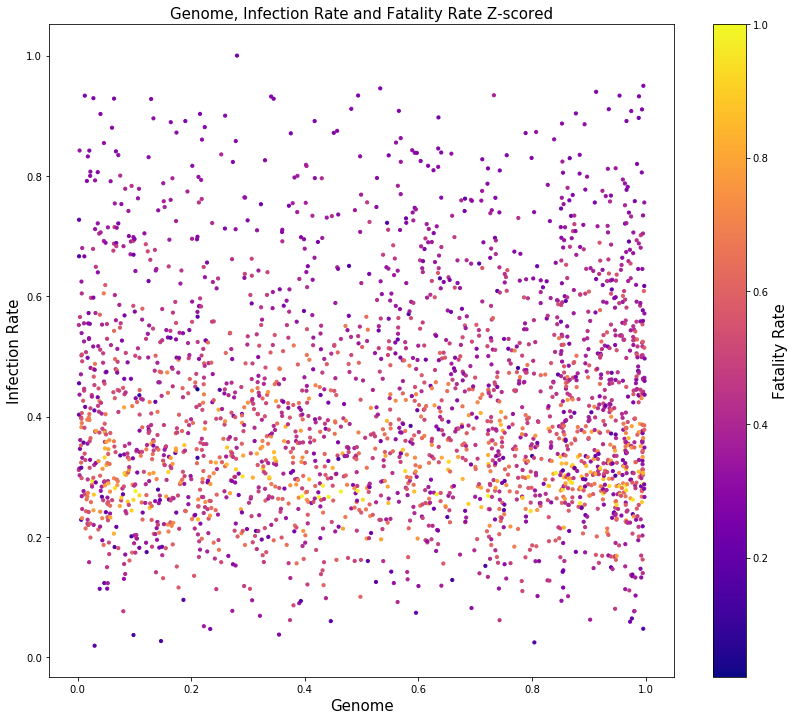

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
#art = ax.scatter(filt_z['genome']*genome_std+genome_mean,filt_z['infection_rate']*inf_std+inf_mean, s=70, c=filt_z['fatality_rate']*fate_std+fate_mean, cmap='plasma')
art = ax.scatter(filt_z['genome'],filt_z['infection_rate'], s=10, c=filt_z['fatality_rate'], cmap='plasma')

ax.set_xlabel('Genome',fontsize=15)
ax.set_ylabel('Infection Rate',fontsize=15)
ax.set_title('Genome, Infection Rate and Fatality Rate Z-scored',fontsize=15)

# labeled = filt_z[~filt_z['mutation'].isna()]
# x = labeled['genome'].values
# y = labeled['infection_rate'].values
# label = labeled['mutation'].values
# texts = []
# for i, txt in enumerate(label):
#     texts.append(ax.text(x[i],y[i],txt))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
cbar = plt.colorbar(art);
cbar.ax.set_ylabel('Fatality Rate',fontsize=15)

### Histogram of highest and lowest fatalities vs countries

In [68]:
for max_fate in filt_z.loc[:,'fatality_rate'].sort_values().iloc[0:30].index:
    fig, ax = plt.subplots(1, 1, figsize=(20, 6))

    country_counts = ast.literal_eval(filt_z.loc[max_fate,'counted_countries'])

    ax.bar(range(len(country_counts.values())),country_counts.values(),width=0.35)
    plt.xticks(range(len(country_counts.values())), country_counts.keys(),fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Mutation Occurrence Histogram',fontsize=15)
    plt.xlabel('Countries',fontsize=12)
    plt.ylabel('Mutation Counts',fontsize=12)
    plt.title(f"{filt_z.loc[max_fate,'descriptor']}")
    #plt.savefig(f"country_distribution/{filt_z.loc[max_fate,'descriptor']}")
    plt.close()

In [47]:
np.concatenate((filt_z[['genome','infection_rate']].values,np.array(((1,2),(1,2)))))

array([[0.00203993, 0.3356194 ],
       [0.00220714, 0.59507242],
       [0.00354479, 0.32613428],
       [0.00625355, 0.34882922],
       [0.00678862, 0.42731541],
       [0.00805939, 0.53006659],
       [0.00805939, 0.26574892],
       [0.01046718, 0.29780119],
       [0.01120289, 0.59811649],
       [0.01638632, 0.85284617],
       [0.01718891, 0.28804403],
       [0.01949637, 0.26042561],
       [0.02200448, 0.35377881],
       [0.02956225, 0.44217234],
       [0.03541451, 0.77694396],
       [0.03982878, 0.55078785],
       [0.04354078, 0.20971983],
       [0.04671772, 0.31413513],
       [0.04772096, 0.41839652],
       [0.0481557 , 0.30791355],
       [0.05066381, 0.34422265],
       [0.05330569, 0.27440899],
       [0.05631542, 0.34631397],
       [0.06086346, 0.28151581],
       [0.06394007, 0.38692977],
       [0.07066181, 0.31568498],
       [0.08079457, 0.73607799],
       [0.08293482, 0.32991207],
       [0.08554326, 0.32680926],
       [0.09667926, 0.30922235],
       [0.

In [ ]:
np.concatentate(filt_z['fatality_rate'].values,np.array())

In [ ]:
# # V=Variogram(filt_z[['genome','infection_rate']].values,filt_z['fatality_rate'].values,
# #            use_nugget=True,n_lags=200,normalize=False,maxlag=0.2)
# V=Variogram(np.concatenate((filt_z[['genome','infection_rate']].values,np.array(((1,2),(1,2))))),
#             filt_z['fatality_rate'].values,
#            use_nugget=True,n_lags=200,normalize=False,maxlag=0.2)
# V.plot()
# #V.fit()
# V.describe()

In [ ]:
# V=Variogram(filt_z[['genome','infection_rate']].values,filt_z['fatality_rate'].values,
#            use_nugget=True,n_lags=200,normalize=False,maxlag=0.2)
V=Variogram(filt_z[['genome','infection_rate']].values,filt_z['fatality_rate'].values,
           use_nugget=False,n_lags=200,normalize=False,maxlag=0.2)
V.plot()
#V.fit()
print(V.parameters) #Range, sill nugget
V.describe()

[0.0017318128728442878, 0.028784747363882337, 0]


{'name': 'spherical',
 'estimator': 'matheron',
 'effective_range': 0.0017318128728442878,
 'sill': 0.028784747363882337,
 'nugget': 0}

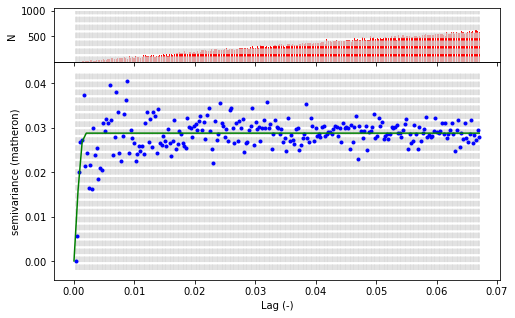

In [17]:
# V=Variogram(filt_z[['genome','infection_rate']].values,filt_z['fatality_rate'].values,
#            use_nugget=True,n_lags=200,normalize=False,maxlag=0.2)
V=Variogram(filt_z[['genome','infection_rate']].values,filt_z['fatality_rate'].values,
           use_nugget=False,n_lags=250,normalize=False,maxlag=0.05)
V.plot()
#V.fit()
print(V.parameters) #Range, sill nugget
V.describe()

[0.26822062525551393, 4.0372964072394465e-08, 0.027927840996594382]


{'name': 'spherical',
 'estimator': 'matheron',
 'effective_range': 0.26822062525551393,
 'sill': 4.0372964072394465e-08,
 'nugget': 0.027927840996594382}

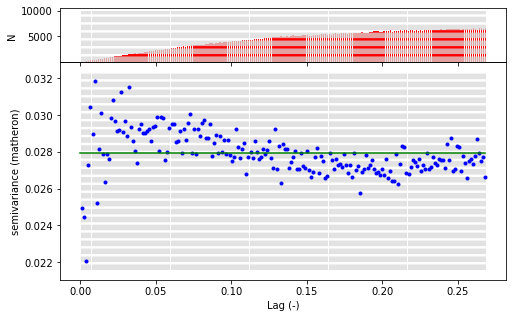

In [11]:
# V=Variogram(filt_z[['genome','infection_rate']].values,filt_z['fatality_rate'].values,
#            use_nugget=True,n_lags=200,normalize=False,maxlag=0.2)
V=Variogram(filt_z[['genome','infection_rate']].values,filt_z['fatality_rate'].values,
           use_nugget=True,n_lags=200,normalize=False,maxlag=0.2)
V.plot()
#V.fit()
print(V.parameters) #Range, sill nugget
V.describe()

In [19]:
ok = OrdinaryKriging(V, min_points=1, max_points=15, mode='estimate')
x_max,x_min = filt_z['genome'].max(),filt_z['genome'].min()
y_max,y_min = filt_z['infection_rate'].max(),filt_z['infection_rate'].min()
xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]


t1 = time.time()
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
t2 = time.time()
print(t2-t1)

s2 = ok.sigma.reshape(xx.shape)

242.90049052238464


Text(0.5, 1.0, 'Genome, Infection Rate and Fatality Rate Z-scored')

/gpfs/home/dshak/anaconda3/envs/py3.8_misc/lib/python3.8/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


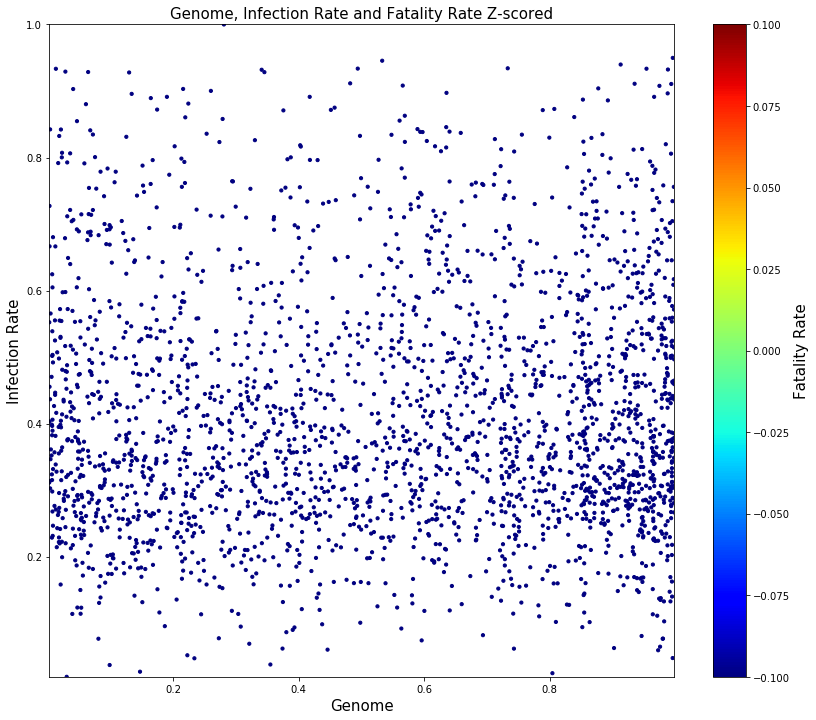

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(14, 12))
mi = np.min((field.min(),filt_z['fatality_rate'].min()))
ma = np.max((field.max(),filt_z['fatality_rate'].max()))
norm = matplotlib.colors.Normalize(vmin=mi,vmax=ma)

#plots
#art = axes.pcolormesh(xx, yy, field, cmap='jet', norm=norm)
axes.scatter(filt_z['genome'],filt_z['infection_rate'], s=10, c=filt_z['fatality_rate'], cmap='jet', norm=norm)

#labels
# labeled = filt_z[~filt_z['mutation'].isna()]
# x = labeled['genome'].values
# y = labeled['infection_rate'].values
# label = labeled['mutation'].values
# texts = []
# for i, txt in enumerate(label):
#     texts.append(axes.text(x[i],y[i],txt))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
cbar = plt.colorbar(art);
cbar.ax.set_ylabel('Fatality Rate',fontsize=15)

axes.set_ylim(min(yy.flatten()),max(yy.flatten()))
axes.set_xlim(min(xx.flatten()),max(xx.flatten()))
axes.set_xlabel('Genome',fontsize=15)
axes.set_ylabel('Infection Rate',fontsize=15)
axes.set_title('Genome, Infection Rate and Fatality Rate Z-scored',fontsize=15)

## See what happens when you remap the whole filed back

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 12))
mi = np.min((field.min(),filt_z['fatality_rate'].min()))
ma = np.max((field.max(),filt_z['fatality_rate'].max()))
norm = matplotlib.colors.Normalize(vmin=mi,vmax=ma)

#plots
art = axes.pcolormesh(xx, yy, field, cmap='plasma', norm=norm)
axes.scatter(filt_z['genome'],filt_z['infection_rate'], s=70, c=filt_z['fatality_rate'], cmap='plasma', norm=norm)

#labels
# labeled = filt_z[~filt_z['mutation'].isna()]
# x = labeled['genome'].values
# y = labeled['infection_rate'].values
# label = labeled['mutation'].values
# texts = []
# for i, txt in enumerate(label):
#     texts.append(axes.text(x[i],y[i],txt))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
cbar = plt.colorbar(art);
cbar.ax.set_ylabel('Fatality Rate',fontsize=15)

axes.set_xlabel('Genome',fontsize=15)
axes.set_ylabel('Infection Rate',fontsize=15)
axes.set_title('Genome, Infection Rate and Fatality Rate Z-scored',fontsize=15)